### The goal of this notebook is to demonstrate building a neural network that can recognize handwritten digits. Given an image of a digit between 0-9, the network will be tasked with correctly identifying the digit. The performance of the network will be demonstrated to improve as it is provided more data to train with.

The original code from the book (http://neuralnetworksanddeeplearning.com/) has been updated for use with Python 3, along with modifications for added functionality

In [3]:
import mnist_loader
import random
import numpy as np
import _pickle as cPickle
import gzip
import random

# Here's what images in the MNIST dataset typically look like:

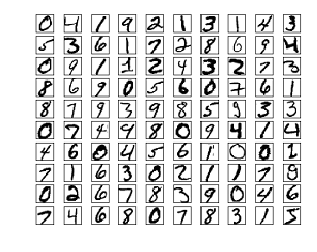

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('images/mnist_100_digits.png')
plt.axis('off')
imgplot = plt.imshow(img)

In [5]:
# Pulled this from the mnist_loader.py file to play a bit with the data
# before putting it through the network

f = gzip.open('./data/mnist.pkl.gz', 'rb')
training_data, validation_data, test_data = cPickle.load(f, encoding="latin1")
f.close()
training_images, training_labels = training_data
print("Number of training images and corresponding labels: ", len(training_images), len(training_labels))

Number of training images and corresponding labels:  50000 50000



Labels from the dataset:  4 2 0 4 (Indices: 2 31429 3286 30590 )


And the images themselves: 


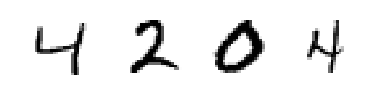

In [6]:
# Display a random image or choose your own number between [0, 50000)
index1 = 2 #random.randint(0, 50000)
index2 = random.randint(0, 50000)
index3 = random.randint(0, 50000)
index4 = random.randint(0, 50000)

# The images are stored in the pickle files as 784 (28x28) pixel long vectors. 
# We reshape them to their original dimensions
plt.subplot(1, 4, 1)
plt.imshow(training_images[index1].reshape(28, 28), cmap = 'binary')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(training_images[index2].reshape(28, 28), cmap = 'binary')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(training_images[index3].reshape(28, 28), cmap = 'binary')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(training_images[index4].reshape(28, 28), cmap = 'binary')
plt.axis('off')

print("\nLabels from the dataset: ", training_labels[index1], training_labels[index2], 
      training_labels[index3], training_labels[index4], 
     "(Indices:", index1, index2, index3, index4,")\n\n\nAnd the images themselves: ")


Label from the dataset:  5 (Index:2850)


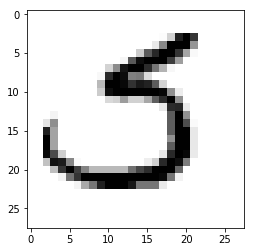

In [7]:
# Just for the heck of it, we can do this for the test dataset too
test_images, test_labels = test_data
index = random.randint(0, 10000)
plt.imshow(test_images[index].reshape(28, 28), cmap = 'binary')
print("\nLabel from the dataset: ", test_labels[index], "(Index:"+ str(index)+")")

## Ok, the datasets seem to be well-labeled.

In [8]:
# Developing a neural network from scratch
# Code from http://neuralnetworksanddeeplearning.com/chap1.html
# Modified to taste, with apologies to Michael Nielsen

import random as rnd
import numpy as np

class Network(object):
    def __init__(self, sizes): # Oh, class constructors!
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
        
    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a # Only the network output is returned
    
    def initial_test(self, test_data, i):
        test_data = list(test_data)
        
        score = self.evaluate(test_data)
        print("Test "+str(i)+":", score, "(",100*score/len(list(test_data)),"%)")
        
        
    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None): # Stochastic Gradient Descent
        training_data = list(training_data)
        n = len(training_data)
        
        if test_data: 
            test_data = list(test_data)
            n_test = len(test_data)
        
        
        for j in range(epochs): # xrange in the original code has been deprecated in Python 3
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if(test_data):
                print("Epoch {}: {}/{}".format(j, self.evaluate(test_data), n_test))
            else:
                print("Epoch {} complete".format(j))
                
    def update_mini_batch(self, mini_batch, eta):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            
        self.weights = [w-(eta/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)]
        self.biases =  [b-(eta/len(mini_batch))*nb for b, nb in zip(self.biases,  nabla_b)]
        
    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        activation = x
        
        activations = [x]
        
        zs = []
        
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
            
        delta = self.cost_derivative(activations[-1], y)*sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta)*sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
            
        return (nabla_b, nabla_w)
    
    def evaluate(self, test_data):
        test_results = [(np.argmax(self.feedforward(x)), y) for (x, y) in test_data]
        
        return sum(int(x==y) for (x, y) in test_results)
    
    def cost_derivative(self, output_activations, y):
        return (output_activations - y)
    
    
def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))     

def bad_classifications(network, test_data):
    misclassified = []
    
    for (x, ground_truth) in test_data:
        output = np.argmax(network.feedforward(x))
        if (output != ground_truth):
            misclassified += [(x, ground_truth, output)]
    
    return misclassified

In [9]:
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
test_data_copy = tuple(test_data)

In [10]:
print("With random weights and biases in the network: ")

for i in range(10):
    net = Network([784, 300, 30, 10])
    net.initial_test(test_data_copy, i+1)

With random weights and biases in the network: 
Test 1: 816 ( 8.16 %)
Test 2: 704 ( 7.04 %)
Test 3: 982 ( 9.82 %)
Test 4: 1140 ( 11.4 %)
Test 5: 973 ( 9.73 %)
Test 6: 970 ( 9.7 %)
Test 7: 921 ( 9.21 %)
Test 8: 767 ( 7.67 %)
Test 9: 1094 ( 10.94 %)
Test 10: 880 ( 8.8 %)


### The network averages an error rate of close to 10%, which is expected of random chance prediction for this task. Using the last randomly initialized network, we begin training our network so that it actually learns.

In [11]:
print("Epoch #: (# of correctly identified digits)/(# of test images)")
net.SGD(training_data, 30, 10, 3.0, test_data=test_data_copy)

Epoch #: (# of correctly identified digits)/(# of test images)
Epoch 0: 9026/10000
Epoch 1: 9286/10000
Epoch 2: 9354/10000
Epoch 3: 9396/10000
Epoch 4: 9411/10000
Epoch 5: 9497/10000
Epoch 6: 9438/10000
Epoch 7: 9555/10000
Epoch 8: 9551/10000
Epoch 9: 9559/10000
Epoch 10: 9562/10000
Epoch 11: 9600/10000
Epoch 12: 9593/10000
Epoch 13: 9573/10000
Epoch 14: 9612/10000
Epoch 15: 9586/10000
Epoch 16: 9632/10000
Epoch 17: 9632/10000
Epoch 18: 9649/10000
Epoch 19: 9634/10000
Epoch 20: 9672/10000
Epoch 21: 9664/10000
Epoch 22: 9663/10000
Epoch 23: 9642/10000
Epoch 24: 9674/10000
Epoch 25: 9668/10000
Epoch 26: 9678/10000
Epoch 27: 9668/10000
Epoch 28: 9673/10000
Epoch 29: 9675/10000


Ground truth: 8 7 4 7 8 4 4 9 2 1 ; Predicted label: 5 3 2 2 9 6 9 1 4 7 


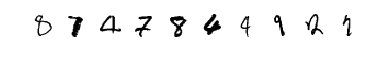

In [40]:
misclassified = bad_classifications(net, test_data_copy)

predicted_labels = "Predicted label: "
actual_labels = "Ground truth: "

n_examples = 10
for i in range(n_examples):
    index = random.randint(0, len(misclassified))
    (x, y, z) = misclassified[index]
    predicted_labels += str(z) + " "
    actual_labels += str(y) + " "
    plt.subplot(1, n_examples, i+1)
    plt.imshow(x.reshape(28, 28), cmap = 'binary')
    plt.axis('off')

print(actual_labels + "; " + predicted_labels)

## As can be seen in the examples above, some digits are actually hard to classify (1 and 7; 4 and 9; 6 and 8 are commonly confused). Others are less evident - 0s are often misclassified as 5s. Other techniques should be explored to improve the performance of this network.

## Yann LeCun has compiled a list of techniques and their corresponding test error rate ( http://yann.lecun.com/exdb/mnist/ ). CNNs have been demonstrated to perform with a less than 1% error rate. Compared to that, the above NN (structured as [784, 30, 30, 10]) averages an error rate of 5%. The next steps will hence be to develop a network that bridges this performance gap.